# River load sensor calibration with machine learning

The original version of this notebook was made by Antoine Lucas (lucas@ipgp.fr) on top of the study made by Amande Roque-Bernard (roquebernard@ipgp.fr) with the help of Gregory Sainton (sainton@ipgp.fr). The current version was made by Leonard Seydoux (seydoux@ipgp.fr) in 2023. In order to know more about the scientific context, please refer to _Roque-Bernard, A., Lucas, A., Gayer, E., Allemand, P., Dessert, C., and Lajeunesse, E.: Phenomenological model of suspended sediment transport in a small catchment, Earth Surf. Dynam., 11, 363–381, https://doi.org/10.5194/esurf-11-363-2023, 2023._

<img src="images/logo-obsera.png" style="margin:20px; height:100px;"/> <img src="images/logo-ipgp-upc.png" height=100 style="margin:20px; height:100px;"/>

## Prerequisites

Before running the notebook, you should make sure that the necessary packages are installed. You can do this by running the following cell. Be sure you are using a correct environment (check the top right corner of the notebook for the name of the environment). Note that there is a blank line between the first import and the other ones. This is because we follow the [PEP8](https://www.python.org/dev/peps/pep-0008/) convention between standard library imports and third party imports.

In [1]:
import glob

import numpy as np
import pandas as pd


## 1. Introduction

Estimating the suspended load within a river is a key issue in geomorphology. The suspended load is often estimated by sampling the water column and measuring the concentration $C_S$ of suspended particles. Although this method is accurate, it is not suitable for long-term monitoring, since it is time-consuming and expensive. A cheaper and faster method is to use turbidity probes. Turbidity probes allow to measure the turbidity $T$ of the water column, which is related to the concentration of suspended particles. However, the relationship between turbidity and suspended load is not straightforward. It depends on the size and the shape of the particles. The goal of this notebook is to calibrate a turbidity probe placed in a river against independent measurements of suspended load. In other terms, we want to find a relationship between the turbidity and the suspended load. And for this, we will use a machine-learning approach.

The dataset comes from the _OBServatoire de l’Eau et de l’éRosion aux Antilles_ ([ObsERA](https://www.ozcar-ri.org/fr/observatoire-obsera/)), an observatory located in Guadeloupe that gives us information on the erosion of this volcanic island in a few watersheds. With this notebook, you will learn how to prepare and clean a dataset. It is likely the most important part of the job. Then, you will play with your first models with the `scikit-learn` library. 


> __Question 1.__ What kind of machine learning problem is this? What is the input $x$, the output $y$? What are the features, the labels, what are the dimensions of the features and the labels spaces? 


## 2. Data loading 

The data for the calibration are stored under the [./data](./data) directory. The data are separated in two subsets, one with suspended load information which contains the independent measurements of suspended load ([`./data/chemistry`](./data/chemistry)) and another one with hydrological information which contains the turbidity and water level measurements ([`./data/hydrology`](./data/hydrology)). 

### 2.1 Load the chemical data

The chemical data comes in a single CSV file located under the [`./data/chemistry`](./data/chemistry) repository. We here load it in a Pandas dataframe with the `pd.read_csv()` function. The goal of this first cell is to correctly parse the data, especially by converting the date and time information into `pd.Timestamp` objects and by selecting the column of interest.

In [4]:
# Declare the path to the data
filepath = "data/chemistry/CE_DIG_OBSERA_RIVERS_2019-09-26.csv"

# Read it into a pandas dataframe
data_chemical = pd.read_csv(filepath, delimiter=";")

# Print the first 5 rows
data_chemical.head()

,Date,Hour,Code Site,Site,Level,Type,Flask,Twater (°C),Suspended Load,pH,...,K,Mg,Ca,HCO3,Cl,SO4,Conductivity at 25°C,NICB (%),Comment,Validate
0,2019-09-20,10:53,GRCCEDIG,RCCEDIG,14.0,2,P,23.3,NaN,7.28,...,NaN,NaN,NaN,30.7,NaN,NaN,64.1,NaN,Alc. mesurée en labo le 20/09/2019; autres par...,NaN
1,2019-07-29,12:52,GRCCEDIG,RCCEDIG,NaN,1,P,NaN,118.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,28.1,NaN,P24,NaN
2,2019-07-28,20:22,GRCCEDIG,RCCEDIG,NaN,1,P,NaN,17.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30.7,NaN,P13,NaN
3,2019-07-28,18:51,GRCCEDIG,RCCEDIG,NaN,1,P,NaN,38.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.3,NaN,P12,NaN
4,2019-07-28,18:36,GRCCEDIG,RCCEDIG,NaN,1,P,NaN,48.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,24.4,NaN,P11,NaN


Note that pandas DataFrames have a special column called the index. This column is used to uniquely identify each row of the DataFrame. By default, the index is a sequence of integers from $0$ to $N-1$, where $N$ is the number of rows in the DataFrame. However, you can also use a column of the DataFrame as the index. In our case, we will use the date of the measurements as the index.

In [3]:
# Parse the date and time columns into a new column
date_and_time = data_chemical["Date"] + " " + data_chemical["Hour"]
data_chemical["datetime"] = pd.to_datetime(date_and_time)

# Set the datetime column as the index
data_chemical.set_index("datetime", inplace=True)
data_chemical.sort_index(inplace=True)

# Check head
print(data_chemical.head())

                           Date   Hour Code Site     Site  Level  Type Flask  \
datetime                                                                       
2006-11-09 09:30:00  2006-11-09  09:30  GRCCEDIG  RCCEDIG   15.0     2     P   
2006-12-05 10:45:00  2006-12-05  10:45  GRCCEDIG  RCCEDIG   97.0     2     P   
2006-12-08 10:00:00  2006-12-08  10:00  GRCCEDIG  RCCEDIG   25.0     2     P   
2006-12-13 09:50:00  2006-12-13  09:50  GRCCEDIG  RCCEDIG   28.0     2     P   
2006-12-15 10:20:00  2006-12-15  10:20  GRCCEDIG  RCCEDIG   64.0     2     P   

                     Twater (°C)  Suspended Load    pH  ...       K      Mg  \
datetime                                                ...                   
2006-11-09 09:30:00         22.2             NaN  7.43  ...  0.4442  1.2939   
2006-12-05 10:45:00         21.4           161.2  6.51  ...  0.3257  0.3962   
2006-12-08 10:00:00         22.2             1.4  7.30  ...  0.5151  1.1061   
2006-12-13 09:50:00         21.5            

Finally, we extract the data of interest here, a.k.a. the suspended load measurements. Note that since this is only a single column from the `df_chemical` DataFrame, the result is a pandas Series.

In [4]:
# Extract the suspended load
suspended_load = data_chemical["Suspended Load"]

# Drop the NaN values
suspended_load.dropna(inplace=True)

# Print the first few rows
print(suspended_load.head())

datetime
2006-12-05 10:45:00    161.2
2006-12-08 10:00:00      1.4
2007-03-06 09:30:00     19.2
2007-03-07 14:30:00     11.3
2007-03-12 10:30:00     29.2
Name: Suspended Load, dtype: float64


In [5]:
print(suspended_load.info())

<class 'pandas.core.series.Series'>
DatetimeIndex: 340 entries, 2006-12-05 10:45:00 to 2019-07-29 12:52:00
Series name: Suspended Load
Non-Null Count  Dtype  
--------------  -----  
340 non-null    float64
dtypes: float64(1)
memory usage: 5.3 KB
None


In [6]:
print(suspended_load.describe())

count     340.000000
mean      121.640176
std       206.564466
min         0.300000
25%        16.700000
50%        55.750000
75%       147.500000
max      1702.000000
Name: Suspended Load, dtype: float64


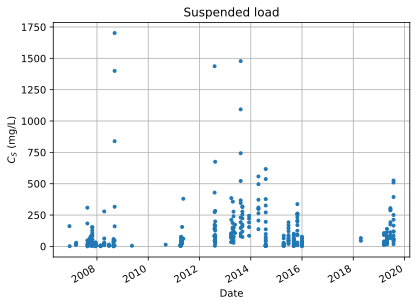

In [7]:
suspended_load.plot(
    style=".",
    xlabel="Date",
    ylabel="$C_S$ (mg/L)",
    grid=True,
    title="Suspended load",
);

### 2.2 Load the hydrological data

In this second part, we will deal with the hydrological data. The goal is to extract the turbidity data and to compare it with the suspended load data. Note that the hydrological data are split into different files. We will have to merge them into a single DataFrame.

In [8]:
# Initialize the list of dataframes for the hydro dataset
filepaths = glob.glob("data/HYDRO/*.csv")

# Initialize an empty list to store the dataframes
data_hydro = []

# Define the options for reading the CSV files
read_options = {
    "sep": ",",
    "na_values": {"-30000.0", "NAN", "1e+10"},
    "comment": "#",
    "parse_dates": ["datetime"],
}

# Get the data from each file, append to the list, and concatenate
data_hydro = pd.concat([pd.read_csv(f, **read_options) for f in filepaths])

# Set the datetime column as the index, and sort the index
data_hydro.set_index("datetime", inplace=True)
data_hydro.sort_index(inplace=True)

# Select interesting columns
data_hydro = data_hydro[["level", "turbidity"]]

# Print info
print(data_hydro.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732981 entries, 2012-05-18 08:30:00 to 2019-07-25 10:15:00
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   level      722105 non-null  float64
 1   turbidity  547116 non-null  float64
dtypes: float64(2)
memory usage: 16.8 MB
None


In [9]:
print(data_hydro.describe())

               level      turbidity
count  722105.000000  547116.000000
mean       21.044671      14.128219
std        10.447657      53.070967
min         6.821000       0.017000
25%        14.348000       1.835140
50%        18.190000       2.975151
75%        24.460000       4.015494
max       222.140000     499.953404


In [10]:
print(data_hydro.head())

                     level  turbidity
datetime                             
2012-05-18 08:30:00  28.96      11.79
2012-05-18 08:35:00  28.90      11.79
2012-05-18 08:40:00  28.97      11.79
2012-05-18 08:45:00  28.86      11.79
2012-05-18 08:50:00  28.70      11.79


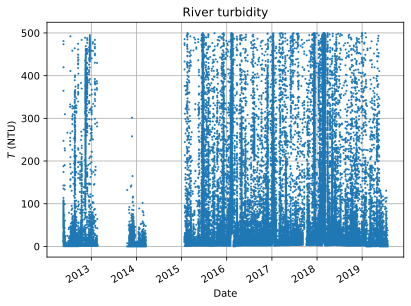

In [11]:
data_hydro["turbidity"].plot(
    xlabel="Date",
    ylabel="$T$ (NTU)",
    grid=True,
    style=".",
    ms=2,
    rasterized=True,
    title="River turbidity",
);

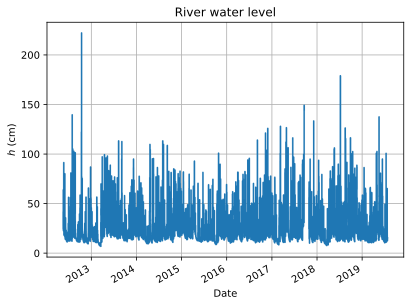

In [12]:
data_hydro["level"].plot(
    xlabel="Date",
    ylabel="$h$ (cm)",
    grid=True,
    rasterized=True,
    title="River water level",
);


## 3. Synchronize the data

You may have realized that the chemical and hydrological data are not synchronized. Actually, the chemical data is sparse in time, whereas the hydrological data is (more or less) continuous with a minimum of 1 measurement every 5 minutes. We will have to synchronize the data to be able to compare them.

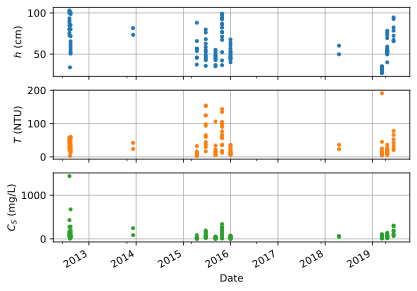

In [13]:
# Get the minimum common start and end dates
start = max(suspended_load.index.min(), data_hydro.index.min())
end = min(suspended_load.index.max(), data_hydro.index.max())

# Trucate the dataframes
suspended_load = suspended_load.truncate(before=start, after=end)
data_hydro_resampled = data_hydro.truncate(before=start, after=end).copy()

# Interpolate on a fine time grid and reindex on the most constraining index
data_hydro_resampled = data_hydro_resampled.resample("1min")
data_hydro_resampled = data_hydro_resampled.interpolate(method="linear", limit=10)

# Reindex
data_hydro_resampled = data_hydro_resampled.reindex(suspended_load.index)

# Gather the data in a single dataframe
data = data_hydro_resampled.copy()
data["suspended_load"] = suspended_load
data.dropna(inplace=True)

# Plot the data
ax = data.plot(
    subplots=True,
    style=".",
    grid=True,
    xlabel="Date",
    legend=False,
);

# Labels
ax[0].set_ylabel("$h$ (cm)")
ax[1].set_ylabel("$T$ (NTU)")
ax[2].set_ylabel("$C_S$ (mg/L)");

## 4. Inspect the data

Now we can start to investigate correlations between the turbidity and the suspended load. We will start by plotting the data. We will also compute the correlation coefficient between the turbidity and the suspended load

array([[<Axes: xlabel='level', ylabel='level'>,
        <Axes: xlabel='turbidity', ylabel='level'>,
        <Axes: xlabel='suspended_load', ylabel='level'>],
       [<Axes: xlabel='level', ylabel='turbidity'>,
        <Axes: xlabel='turbidity', ylabel='turbidity'>,
        <Axes: xlabel='suspended_load', ylabel='turbidity'>],
       [<Axes: xlabel='level', ylabel='suspended_load'>,
        <Axes: xlabel='turbidity', ylabel='suspended_load'>,
        <Axes: xlabel='suspended_load', ylabel='suspended_load'>]],
      dtype=object)

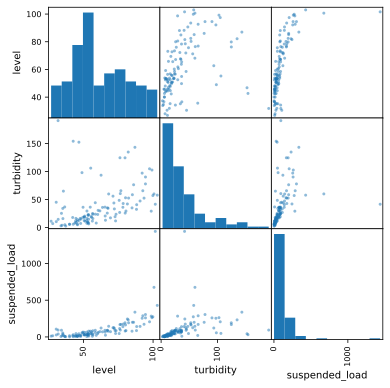

In [14]:
pd.plotting.scatter_matrix(data, grid=True, figsize=(6, 6))


## 4. Machine learning approach

In this section, we will try several machine learning models to find the best one to predict the suspended load from the turbidity. We will use the `scikit-learn` library. 

We first need to formalize the problem we are trying to solve. The goal here is to find the relationship between the turbidity $x$ and the suspended load $y$. In other terms, we want to find a function $f_\theta$ such that 

$$f_\theta(x) = y$$

This function is called a model, and its parameters are noted $\theta$ = $(\theta_1, \theta_2, \dots, \theta_n)$. We will try several models and compare them to find the best one, namely $\theta^*$ = $(\theta_1^*, \theta_2^*, \dots, \theta_n^*)$, that minimizes the error between the predicted suspended load and the measured suspended load.

### 4.1. Linear regression

There is no real need to use the `scikit-learn` library to perform a linear regression. However, it is a good way to start to use the library and understand its _greybox_ approach. In the next cell, we will import a linear regression model, instantiate it, fit it to the data and plot the result. Following the notations above, the linear regression uses a model of the form

$$y = f_\theta(x) = \theta_1 x + \theta_0$$

The parameters $\theta_0$ and $\theta_1$ are called the intercept and the slope, respectively. The goal of the linear regression is to find the best values for these parameters. In other terms, we want to find the best line that fits the data.

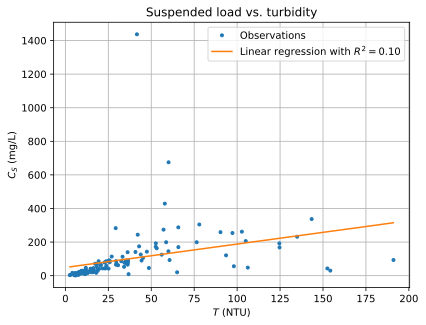

In [15]:
from sklearn.linear_model import LinearRegression

# Rename vectors
y = data["suspended_load"].to_numpy()
x = data["turbidity"].to_numpy()

# Reshape the vectors
y = y.reshape(-1, 1)
x = x.reshape(-1, 1)

# Create a linear regression object
model_1 = LinearRegression()

# Fit the model
model_1.fit(x, y)

# Plot the results
ax = data.plot(
    x="turbidity",
    y="suspended_load",
    style=".",
    grid=True,
    xlabel="$T$ (NTU)",
    ylabel="$C_S$ (mg/L)",
    title="Suspended load vs. turbidity",
    label="Observations",
)

# Plot the linear regression
label = f"Linear regression with $R^2 = {model_1.score(x, y):.2f}$"
ax.plot(x, model_1.predict(x), label=label)

# Add the legend
ax.legend();

### 4.2. Robust linear regression

It is obvious that the linear regression struggles with outliers. In the next cell, we will use a robust linear regression model to fit the data. The robust linear regression is a linear regression that is less sensitive to outliers. It performs the linear regression on a subset of the data and iteratively removes the outliers. 

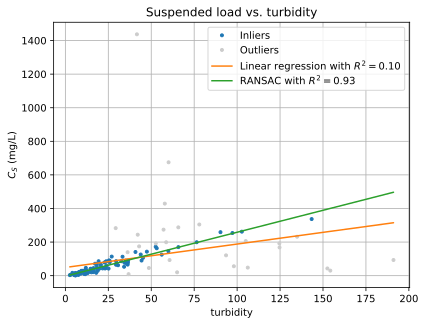

In [16]:
from sklearn.linear_model import RANSACRegressor

# Rename vectors
y = data["suspended_load"].to_numpy()
x = data["turbidity"].to_numpy()

# Reshape the vectors
y = y.reshape(-1, 1)
x = x.reshape(-1, 1)

# Create a linear regression object
model_2 = RANSACRegressor(min_samples=0.5)

# Fit the model
model_2.fit(x, y)

# Get the inliers
inliers = model_2.inlier_mask_

# Plot inliers
ax = data[inliers].plot(
    x="turbidity",
    y="suspended_load",
    style=".",
    grid=True,
    xlabel="$T$ (NTU)",
    ylabel="$C_S$ (mg/L)",
    title="Suspended load vs. turbidity",
    label="Inliers",
)

# Plot outliers
data[~inliers].plot(
    x="turbidity",
    y="suspended_load",
    style=".",
    ax=ax,
    label="Outliers",
    color="0.8",
)

# Plot the linear regression
label = f"Linear regression with $R^2 = {model_1.score(x, y):.2f}$"
ax.plot(x, model_1.predict(x), label=label)

# Plot the robust linear regression
label = f"RANSAC with $R^2 = {model_2.score(x[inliers], y[inliers]):.2f}$"
ax.plot(x, model_2.predict(x), label=label)

# Add the legend
ax.legend()
ax.grid(True)


### 4.3. Linear regression in the log-log space

The linear regression in the log-log space is a linear regression that is performed on the logarithm of the data. It is often used when the data spans several orders of magnitude. In our case, the suspended load spans 4 orders of magnitude. In the next cell, we will perform a linear regression in the log-log space.

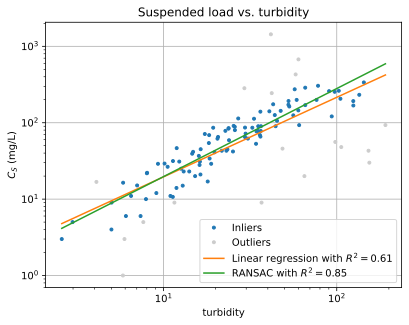

In [17]:
# Rename vectors
y = data["suspended_load"].to_numpy()
x = data["turbidity"].to_numpy()

# Reshape the vectors
y = y.reshape(-1, 1)
x = x.reshape(-1, 1)

# Transform in the log space
y = np.log(y)
x = np.log(x)

# Create a linear regression object
model_3 = LinearRegression()
model_4 = RANSACRegressor(min_samples=0.5)

# Fit the model
model_3.fit(x, y)
model_4.fit(x, y)

# Get the inliers
inliers = model_4.inlier_mask_

# Plot inliers
ax = data[inliers].plot(
    x="turbidity",
    y="suspended_load",
    style=".",
    grid=True,
    xlabel="$T$ (NTU)",
    ylabel="$C_S$ (mg/L)",
    title="Suspended load vs. turbidity",
    label="Inliers",
)

# Plot outliers
data[~inliers].plot(
    x="turbidity",
    y="suspended_load",
    style=".",
    ax=ax,
    label="Outliers",
    color="0.8",
)

x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)

# Plot the linear regression
label = f"Linear regression with $R^2 = {model_3.score(x, y):.2f}$"
ax.plot(np.exp(x_range), np.exp(model_3.predict(x_range)), label=label)

# Plot the robust linear regression
label = f"RANSAC with $R^2 = {model_3.score(x[inliers], y[inliers]):.2f}$"
ax.plot(np.exp(x_range), np.exp(model_4.predict(x_range)), label=label)

# Add the legend
ax.legend()
ax.grid(True)
ax.set_xscale("log")
ax.set_yscale("log")